# Infer failure probability

### Available features
Weather features : 
- PRCP : Precipitation (tenths of mm)
- SNOW : Snowfall (mm)
- SNWD : Snow depth (mm)
- TAVG : Average daily temperature (tenths of degrees C)
- TMIN : Minimum temperature (tenths of degrees C)
- TMAX : Maximum temperature (tenths of degrees C)
- ASTP : Average Station Level Pressure for the day (hPa * 10)
- AWND : Average daily wind speed (tenths of meters per second)
- FRGB : Base of frozen ground layer (cm)
- FRTH : Top of frozen ground layer (cm)
- GAHT : Difference between river and gauge height (cm)
- WSF1 : Fastest 1-minute wind speed (tenths of meters per second)

Load features :
(everyting is unitless, as we took the time series for each states that we have then normalized by the historical maximum value)
- PAVG : Daily load average
- PMIN : Daily load minimum
- PMAX : Daily load maximum
- PDMMAX : Daily hour to hour maximum load change
- PFMAX : Daily hourly maximum signed difference between real and forecasted power load (positive if real > forecast)

Temporal features :
- Season : Winter (0), Spring (1), Summer (2), Fall (3)
- 

Geographical features :
- State : US state or Canadian province name

### Targets to predict
- **'CauseCodeCluster'** : Predict a failure type. Since there are too many cause codes (> 1,000) we first clusterize the cause codes using kmeans on the features and then predict the cause code cluster
- **'Frequency'** : Predict the failure frequency
- **'1-Frequency'** : Predict the "surviving" frequency, i.e 1-Failure frequency. THis is useful for using loss function that evaluate relative gaps such as MAPE

### Evaluation Metric
- RMSE
- MAE
- MAPE

In [2]:
# Import libraries

# Data processing and manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.cluster import KMeans
import xgboost as xgb

# Other
import importlib
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import inferenceModels as im    # your file



# Mutual information
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

# import knncmi
from npeet.entropy_estimators import cmi
from npeet import entropy_estimators as ee

from typing import Iterable
from pathlib import Path

from mutual_information import compute_mutual_information_auto


importlib.reload(im)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/miniconda3/envs/ScenarioGeneration/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/miniconda3/envs/ScenarioGeneration/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/miniconda3/envs/ScenarioGeneration/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in

ModuleNotFoundError: No module named 'npeet'

In [4]:
weather_data_file = 'DATA/weather_data_per_state_all.csv'
power_load_file = 'DATA/power_load_input.csv'
weather_data = pd.read_csv(weather_data_file, index_col=[0,1], parse_dates=[0])
power_load_data = pd.read_csv(power_load_file, index_col=[0,1], parse_dates=[0])


# features_names=['PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMIN', 'TMAX', 'ASTP', 'AWND', 
#                 'PAVG', 'PMIN', 'PMAX', 'PDMAX',
#                 'Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']
features_names = list(weather_data.columns) + list(power_load_data.columns) + ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']
features_names = list(set(features_names)-set(['EventStartDT', 'Date']))


/var/folders/01/r5kd5w_d2g3f08450t2g_p5h0000gn/T/ipykernel_82958/4107358550.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_data = pd.read_csv(weather_data_file, index_col=[0,1], parse_dates=[0])
/var/folders/01/r5kd5w_d2g3f08450t2g_p5h0000gn/T/ipykernel_82958/4107358550.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_data = pd.read_csv(weather_data_file, index_col=[0,1], parse_dates=[0])


In [5]:
merged_count_df, feature_names, target_columns = im.preprocess_data(failure_path='DATA/filtered_events.csv',
                                                                event_count_path='DATA/event_count.csv',
                                                                weather_path=weather_data_file,
                                                                power_load_path=power_load_file,
                                                                feature_names=features_names,
                                                                target='Unit_Failure',  # 'Frequency' or 'Unit_Failure'
                                                                state_one_hot=False,
                                                                cause_code_n_clusters=1)

discrete_features = ['C_0', 'Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']+[f for f in feature_names if f.startswith('State')]
merged_count_df[discrete_features] = merged_count_df[discrete_features].astype('int')

stand_cols = [f for f in feature_names if not f.startswith('State_') and not f in ['Holiday', 'Weekend']]

print(f"Features : {feature_names}")
print(f"Targets : {target_columns}")
print(f"Dataset shape: {merged_count_df.shape}")
merged_count_df.head()

Dropping weather columns with >20.0% NaN: ['ADPT', 'WindChill', 'ASLP', 'RHAV', 'WESF', 'RHMN', 'THIC', 'RHMX', 'TSUN', 'WESD', 'WSFG', 'StormSeverity', 'EVAP', 'HeatIndex', 'AWND', 'ASTP']
Features : ['TMAX', 'HDD', 'SNWD', 'SnowSeverity', 'HDD_7d', 'Season', 'FDD', 'TAVG', 'PMIN', 'ExtremeCold', 'PRCP', 'FDD_7d', 'DayOfWeek', 'PRCP_30d_sum', 'ExtremeHeat', 'CDD', 'TMIN', 'Holiday', 'PDMAX', 'Weekend', 'CDD_7d', 'Month', 'PMAX', 'DayOfYear', 'ExtremeWind', 'PAVG', 'PRCP_30dz', 'SNOW', 'State']
Targets : ['C_0']
Dataset shape: (7729103, 31)


,TMAX,HDD,SNWD,SnowSeverity,HDD_7d,Season,FDD,TAVG,PMIN,ExtremeCold,...,Month,PMAX,DayOfYear,ExtremeWind,PAVG,PRCP_30dz,SNOW,State,C_0,Data_weight
0,14.277885,10.838235,0.0,0.0,33.698307,2,0.000,7.161765,0.010154,0.0,...,11,0.012154,327,0.0,0.011055,-0.449561,0.0,8,0,1.0
1,2.195798,21.875000,0.0,0.0,110.783333,3,3.875,-3.875000,0.014643,1.0,...,1,0.018695,2,0.0,0.016471,-0.647003,0.0,8,0,1.0
2,31.865438,0.000000,0.0,0.0,0.052000,2,0.000,25.700000,0.080136,0.0,...,10,0.130084,287,0.0,0.103926,0.207356,0.0,40,0,1.0
3,8.363351,16.124324,0.0,0.0,57.740736,3,0.000,1.875676,0.000126,0.0,...,1,0.000182,4,0.0,0.000154,1.136639,0.0,30,0,1.0
4,26.489024,0.000000,0.0,0.0,0.000000,2,0.000,19.259259,0.000041,0.0,...,11,0.000063,318,0.0,0.000053,-0.644081,0.0,7,0,1.0


## Mutual information

In [9]:
discrete_vars = [False if f not in discrete_features else True for f in feature_names]

X_train= merged_count_df.loc[:int(0.00001*len(merged_count_df)), feature_names].to_numpy()
y_train= merged_count_df.loc[:int(0.00001*len(merged_count_df)), target_columns].to_numpy().ravel()

In [11]:
discrete_vars = [False if f not in discrete_features else True for f in feature_names]
data_short = merged_count_df.copy()
X_train = data_short[feature_names].to_numpy()
y_train = data_short[target_columns].to_numpy().ravel()

In [12]:
mutual_information = mutual_info_classif(X_train, y_train, discrete_features=discrete_vars,
                                         n_neighbors=3)

KeyboardInterrupt: 

In [ ]:
mutual_information = pd.Series(mutual_information, index=feature_names).sort_values(ascending=True)

In [43]:
for i,j in enumerate(np.arange(2,10)):
    print(i,j)

0 2
1 3
2 4
3 5
4 6
5 7
6 8
7 9


In [26]:
mutual_information = pd.read_csv('Results/mutual_information/mutual_information_ranking_k10.csv', index_col=0)

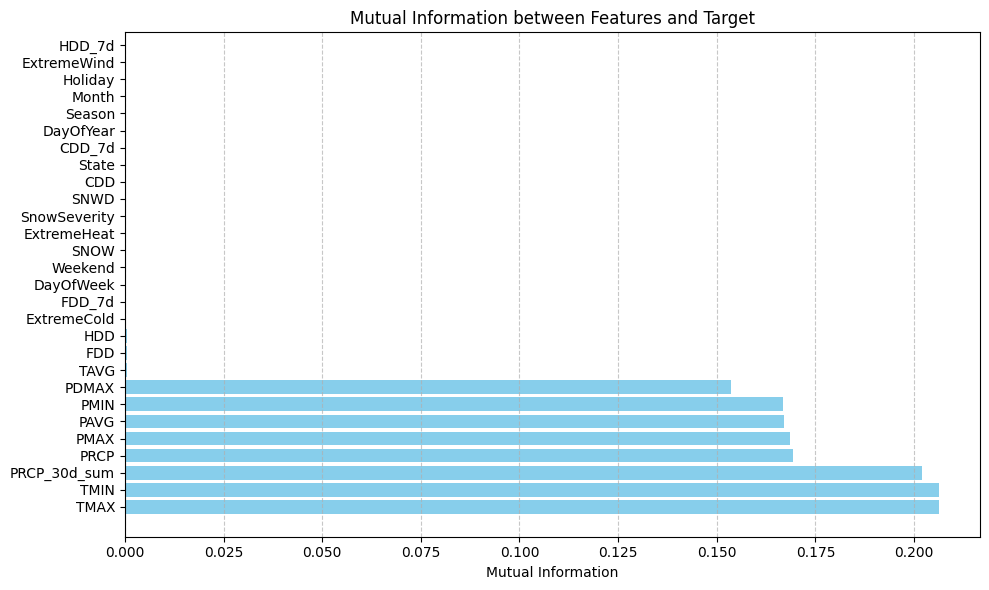

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(mutual_information.index, mutual_information, color='skyblue')
ax.set_xlabel('Mutual Information')
ax.set_title('Mutual Information between Features and Target')
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [26]:
def _is_discrete_series(s: pd.Series, discrete_features: set[str]) -> bool:
    """Decide discreteness: explicit list first; otherwise dtype heuristic."""
    if s.name in discrete_features:
        return True

In [37]:
from npeet import entropy_estimators as ee
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Iterable

def _is_discrete_series(s: pd.Series, discrete_features: set[str]) -> bool:
    if s.name in discrete_features:
        return True
    return pd.api.types.is_integer_dtype(s) or s.nunique(dropna=False) <= max(20, int(0.01*len(s)))

def _as_cont2d(col: pd.Series) -> np.ndarray:
    return col.to_numpy(dtype=float, copy=False).reshape(-1, 1)

def _as_disc1d(col: pd.Series) -> np.ndarray:
    return col.astype(int).to_numpy(copy=False)

def compute_mutual_information_auto(
    df: pd.DataFrame,
    feature_names: list[str],
    target_col: str,
    discrete_features: Iterable[str] = (),
    k: int = 3,
    use_rows: pd.Index | None = None,
    out_csv: str = "Results/mutual_information_ranking.csv",
    standardize_continuous: bool = False,
) -> pd.DataFrame:
    """
    Auto-choose NPEET estimator:
      - disc X, disc Y        -> ee.midd(x1d, y1d)
      - cont X, disc Y        -> ee.micd(X2d, y2d, k)
      - disc X, cont Y        -> ee.micd(Y2d, x2d, k)   # swap args
      - cont X, cont Y        -> ee.mi(X2d, Y2d, k)
    """
    discrete_set = set(discrete_features)
    data = df.loc[use_rows] if use_rows is not None else df

    # Remove rows with any NaNs across used columns
    used_cols = [target_col] + list(feature_names)
    data = data.dropna(subset=used_cols)

    # Target typing + (optional) standardization plan
    y_is_disc = _is_discrete_series(data[target_col], discrete_set)
    if y_is_disc:
        y_disc_1d = _as_disc1d(data[target_col])          # for midd
        y_disc_2d = y_disc_1d.reshape(-1, 1)              # for micd
        y_cont_2d = None
    else:
        y_cont_2d = _as_cont2d(data[target_col])
        y_disc_1d = y_disc_2d = None

    if standardize_continuous:
        cont_cols = [f for f in feature_names if not _is_discrete_series(data[f], discrete_set)]
        if not y_is_disc and target_col not in cont_cols:
            cont_cols.append(target_col)
        if cont_cols:
            mu = data[cont_cols].mean()
            sd = data[cont_cols].std(ddof=0).replace(0, 1.0)
            data.loc[:, cont_cols] = (data[cont_cols] - mu) / sd

    scores = {}
    for f in feature_names:
        x_is_disc = _is_discrete_series(data[f], discrete_set)

        if x_is_disc and y_is_disc:
            val = ee.midd(_as_disc1d(data[f]), y_disc_1d)

        elif (not x_is_disc) and y_is_disc:
            # X continuous, Y discrete
            val = ee.micd(_as_cont2d(data[f]), y_disc_2d, k=k)

        elif x_is_disc and (not y_is_disc):
            # X discrete, Y continuous  -> swap args for micd
            val = ee.micd(y_cont_2d, _as_disc1d(data[f]).reshape(-1,1), k=k)

        else:
            # both continuous
            val = ee.mi(_as_cont2d(data[f]), y_cont_2d, k=k)

        scores[f] = float(val)

    mi_df = (pd.DataFrame({"feature": list(scores.keys()), "mi": list(scores.values())})
             .sort_values("mi", ascending=False, ignore_index=True))

    Path(out_csv).parent.mkdir(parents=True, exist_ok=True)
    mi_df.to_csv(out_csv, index=False)
    print(f"Saved MI ranking to {out_csv}")
    return mi_df


In [39]:
# Make it comparable to your sklearn run (same rows)
n = len(merged_count_df)
train_end = 10000#int(0.8 * n)
train_idx = merged_count_df.index[:]

mi_df = compute_mutual_information_auto(
    df=merged_count_df,
    feature_names=feature_names,
    target_col="C_0",                     # or your other target
    discrete_features=discrete_features,  # your explicit list (best source of truth)
    k=3,                                  # match sklearn's n_neighbors for fairer comparison
    use_rows=train_idx,
    out_csv="Results/mutual_information_ranking.csv",
    standardize_continuous=False,         # set True if scales vary a lot
)


/opt/miniconda3/envs/ScenarioSimulation/lib/python3.13/site-packages/npeet/entropy_estimators.py:29: RuntimeWarning: divide by zero encountered in log
  return (const + n_features * np.log(nn).mean()) / log(base)
/opt/miniconda3/envs/ScenarioSimulation/lib/python3.13/site-packages/npeet/entropy_estimators.py:29: RuntimeWarning: divide by zero encountered in log
  return (const + n_features * np.log(nn).mean()) / log(base)
/opt/miniconda3/envs/ScenarioSimulation/lib/python3.13/site-packages/npeet/entropy_estimators.py:235: RuntimeWarning: invalid value encountered in scalar subtract
  return abs(entropy_x - entropy_x_given_y)  # units already applied
/opt/miniconda3/envs/ScenarioSimulation/lib/python3.13/site-packages/npeet/entropy_estimators.py:29: RuntimeWarning: divide by zero encountered in log
  return (const + n_features * np.log(nn).mean()) / log(base)
/opt/miniconda3/envs/ScenarioSimulation/lib/python3.13/site-packages/npeet/entropy_estimators.py:29: RuntimeWarning: divide by ze

Saved MI ranking to Results/mutual_information_ranking.csv


In [4]:
# --- helpers for NPEET formatting ---
def _to_list2d(col: pd.Series, dtype=float):
    """(n,) -> [[v1],[v2],...] as python lists, dtype-cast."""
    return col.to_numpy(dtype=dtype, copy=False).reshape(-1, 1).tolist()

def _to_list2d_matrix(df: pd.DataFrame, dtype=float):
    """(n,d) -> [[...d...], ...] as python lists, dtype-cast."""
    return df.to_numpy(dtype=dtype, copy=False).tolist()

def _jitter_if_discrete(col: pd.Series, is_discrete: bool, eps=1e-10, seed=0):
    """
    KSG estimators assume continuous vars (no exact ties).
    For discrete vars, add tiny noise to break ties safely.
    """
    if not is_discrete:
        return _to_list2d(col, dtype=float)
    rng = np.random.default_rng(seed)
    arr = col.to_numpy(dtype=float, copy=False)
    arr = arr + rng.normal(0.0, eps, size=arr.shape)
    return arr.reshape(-1, 1).tolist()

In [17]:
discrete_set = set(discrete_features)

MAX_N = 100_000
if len(merged_count_df) > MAX_N:
    # stratify on C_0 if it’s highly imbalanced; here we do a simple head sample for clarity
    data_short = merged_count_df.sample(n=MAX_N, random_state=42)
else:
    data_short = merged_count_df

In [12]:
Y = _jitter_if_discrete(data_short['C_0'], is_discrete=True)

mi_scores = {}
for f in feature_names:
    X = _jitter_if_discrete(data_short[f], is_discrete=(f in discrete_set))
    val = ee.mi(X, Y, k=10)
    mi_scores[f] = float(val)

mi_df = (
    pd.DataFrame({"feature": list(mi_scores.keys()), "mi": list(mi_scores.values())})
    .sort_values("mi", ascending=False, ignore_index=True)
)

# Ensure output directory exists
mi_df

,feature,mi
0,Holiday,1.394053
1,Weekend,1.389647
2,Season,1.387514
3,DayOfWeek,1.365205
4,Month,1.363995
5,State,1.299881
6,DayOfYear,0.674736
7,PRCP,0.002118
8,ASTP,0.001668
9,SNWD,0.001429


In [30]:
kept_features = []
features_cmi = {'rank':[], 'feature':[], 'cmi':[]}
for i in range(len(feature_names)):
    mutual_info = {}
    for f in set(feature_names) - set(kept_features):
        cmi = knncmi.cmi(x=['C_0'],
                        y=[f],
                        z=kept_features,
                        data=data_short[['C_0', f] + kept_features],
                        k=3,
                        discrete_dist=1)
        mutual_info[f] = cmi
    mutual_info = pd.Series(mutual_info).sort_values(ascending=False)

    best_f = mutual_info.index[0]
    kept_features.append(best_f)
    features_cmi['rank'].append(i+1)
    features_cmi['feature'].append(best_f)
    features_cmi['cmi'].append(mutual_info[best_f])

    print(f"Rank {i+1}: {best_f} with CMI {mutual_info[best_f]}")



Rank 1: TMIN with CMI 0.0019244122919619133
Rank 2: TAVG with CMI 0.0012718776794792142
Rank 3: State with CMI 0.00029690476190476184
Rank 4: Month with CMI 4.000000000000004e-05
Rank 5: DayOfYear with CMI 0.0
Rank 6: PDMAX with CMI 0.0


KeyboardInterrupt: 

In [31]:
df_cmi = pd.DataFrame({
    'feature': features_cmi['feature'],
    'cmi': features_cmi['cmi']
}, index=features_cmi['rank'])

In [36]:
df_cmi = pd.DataFrame(features_cmi)

In [34]:
df_cmi

,rank,feature,cmi
0,1,TMIN,0.001924
1,2,TAVG,0.001272
2,3,State,0.000297
3,4,Month,0.000040
4,5,DayOfYear,0.000000
5,6,PDMAX,0.000000


In [16]:
best_f

'Season'

In [ ]:
mutual_info[]

Season       0.004560
Month        0.003856
TMAX         0.003800
AWND         0.003514
PRCP         0.003389
TAVG         0.003381
SNOW         0.002897
SNWD         0.002745
State        0.002367
DayOfWeek    0.002319
TMIN         0.001684
DayOfYear    0.001394
Holiday      0.001133
ASTP         0.000644
PMAX         0.000098
PMIN         0.000000
PAVG         0.000000
PDMAX        0.000000
Weekend      0.000000
dtype: float64

In [10]:
knncmi.cmi(x=['C_0'],
           y=['PAVG'],
           z=['TMIN'],
           data=data_short[['C_0', 'PAVG', 'TMIN']],
           k=10,
           discrete_dist=1)

np.float64(8.367991698635158e-05)

In [11]:
knncmi.cmi(x=['C_0'],
           y=['TMAX', 'PAVG'],
           z=['TMIN'],
           data=data_short[['C_0', 'TMAX', 'TMIN', 'PAVG']],
           k=3,
           discrete_dist=1)

np.float64(0.0005589852352817538)

In [9]:
knncmi.cmi(x=['C_0'],
           y=['PAVG'],
           z=[],
           data=data_short[['C_0', 'PAVG']],
           k=3,
           discrete_dist=1)

np.float64(0.0006824662175290875)

In [7]:
knncmi.cmi(x=['C_0'],
           y=['TMAX'],
           z=['TMIN', 'PAVG'],
           data=data_short[['C_0', 'TMAX', 'TMIN', 'PAVG']],
           k=3,
           discrete_dist=1)

np.float64(0.0005268743306325664)

In [41]:
# --- helpers for NPEET formatting ---
def _to_list2d(col: pd.Series, dtype=float):
    """(n,) -> [[v1],[v2],...] as python lists, dtype-cast."""
    return col.to_numpy(dtype=dtype, copy=False).reshape(-1, 1).tolist()

def _to_list2d_matrix(df: pd.DataFrame, dtype=float):
    """(n,d) -> [[...d...], ...] as python lists, dtype-cast."""
    return df.to_numpy(dtype=dtype, copy=False).tolist()

def _jitter_if_discrete(col: pd.Series, is_discrete: bool, eps=1e-10, seed=0):
    """
    KSG estimators assume continuous vars (no exact ties).
    For discrete vars, add tiny noise to break ties safely.
    """
    if not is_discrete:
        return _to_list2d(col, dtype=float)
    rng = np.random.default_rng(seed)
    arr = col.to_numpy(dtype=float, copy=False)
    arr = arr + rng.normal(0.0, eps, size=arr.shape)
    return arr.reshape(-1, 1).tolist()

In [ ]:
discrete_set = set(discrete_features)

MAX_N = 1_000
if len(merged_count_df) > MAX_N:
    # stratify on C_0 if it’s highly imbalanced; here we do a simple head sample for clarity
    data_short = merged_count_df.sample(n=MAX_N, random_state=42)
else:
    data_short = merged_count_df

In [47]:
MAX_N = 1_000
if len(merged_count_df) > MAX_N:
    # stratify on C_0 if it’s highly imbalanced; here we do a simple head sample for clarity
    data_short = merged_count_df.sample(n=MAX_N, random_state=42)
else:
    data_short = merged_count_df

In [48]:
kept_features = []
features_cmi = {'rank': [], 'feature': [], 'cmi': []}

for i in range(len(feature_names)):
    scores = {}
    candidates = list(set(feature_names) - set(kept_features))
    # Precompute X once (your "target" side of CMI)
    X = _jitter_if_discrete(data_short['C_0'], is_discrete=True)

    # Precompute Z once per iteration (growing set of already selected features)
    if kept_features:
        Z = _to_list2d_matrix(data_short[kept_features], dtype=float)
    else:
        Z = None  # means we'll compute MI(X;Y) in the first round

    for f in candidates:
        Y = _jitter_if_discrete(data_short[f], is_discrete=(f in discrete_set))
        if Z is None:
            # First iteration: I(X;Y)
            val = ee.mi(X, Y, k=3)
        else:
            # Subsequent iterations: I(X;Y|Z)
            val = ee.cmi(X, Y, Z, k=3)
        scores[f] = float(val)

    # pick best, record, and continue
    best_f = max(scores, key=scores.get)
    kept_features.append(best_f)
    features_cmi['rank'].append(i + 1)
    features_cmi['feature'].append(best_f)
    features_cmi['cmi'].append(scores[best_f])

    print(f"Rank {i+1}: {best_f} with {'MI' if Z is None else 'CMI'} {scores[best_f]:.6f}")

df_cmi = pd.DataFrame(features_cmi)

Rank 1: Holiday with MI 1.392186
Rank 2: Weekend with CMI 1.376328
Rank 3: DayOfWeek with CMI 1.308914
Rank 4: Season with CMI 1.159506
Rank 5: Month with CMI 0.697630
Rank 6: AWND with CMI 0.946532
Rank 7: PMIN with CMI 0.953621
Rank 8: PMAX with CMI 0.953621
Rank 9: PAVG with CMI 0.952900
Rank 10: PDMAX with CMI 0.952900
Rank 11: SNOW with CMI 0.828347
Rank 12: SNWD with CMI 0.659672
Rank 13: State with CMI 0.229091
Rank 14: PRCP with CMI 0.208537
Rank 15: TAVG with CMI -0.082418
Rank 16: TMIN with CMI -0.176673
Rank 17: TMAX with CMI -0.267067
Rank 18: DayOfYear with CMI -0.454181
Rank 19: ASTP with CMI -0.497302


In [49]:
df_cmi

,rank,feature,cmi
0,1,Holiday,1.392186
1,2,Weekend,1.376328
2,3,DayOfWeek,1.308914
3,4,Season,1.159506
4,5,Month,0.697630
5,6,AWND,0.946532
6,7,PMIN,0.953621
7,8,PMAX,0.953621
8,9,PAVG,0.952900
9,10,PDMAX,0.952900


In [ ]:
for i in range(len(feature_names)):
    scores = {}
    candidates = list(set(feature_names) - set(kept_features))
    # Precompute X once (your "target" side of CMI)
    X = _jitter_if_discrete(data_short['C_0'], is_discrete=True)

    # Precompute Z once per iteration (growing set of already selected features)
    if kept_features:
        Z = _to_list2d_matrix(data_short[kept_features], dtype=float)
    else:
        Z = None  # means we'll compute MI(X;Y) in the first round

    for f in candidates:
        Y = _jitter_if_discrete(data_short[f], is_discrete=(f in discrete_set))
        if Z is None:
            # First iteration: I(X;Y)
            val = ee.mi(X, Y, k=3)
        else:
            # Subsequent iterations: I(X;Y|Z)
            val = ee.cmi(X, Y, Z, k=3)
        scores[f] = float(val)

    # pick best, record, and continue
    best_f = max(scores, key=scores.get)
    kept_features.append(best_f)
    features_cmi['rank'].append(i + 1)
    features_cmi['feature'].append(best_f)
    features_cmi['cmi'].append(scores[best_f])

    print(f"Rank {i+1}: {best_f} with {'MI' if Z is None else 'CMI'} {scores[best_f]:.6f}")

df_cmi = pd.DataFrame(features_cmi)

# Conditional mutual information

In [16]:
# from npeet import entropy_estimators as ee
import numpy as np
import pandas as pd

import inferenceModelsV2 as im
from npeet import entropy_estimators as ee


In [12]:
features_names=['PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMIN', 'TMAX', 'ASTP', 'AWND', 
                'PAVG', 'PMIN', 'PMAX', 'PDMAX',
                'Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']


merged_count_df, feature_names, target_columns = im.preprocess_data(failure_path='DATA/filtered_events.csv',
                                                                event_count_path='DATA/event_count.csv',
                                                                weather_path='DATA/weather_state_day.csv',
                                                                power_load_path='DATA/power_load_input.csv',
                                                                feature_names=features_names,
                                                                target='Unit_Failure',  # 'Frequency' or 'Unit_Failure'
                                                                state_one_hot=False,
                                                                cause_code_n_clusters=1)

discrete_features = ['C_0', 'Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']+[f for f in feature_names if f.startswith('State')]
merged_count_df[discrete_features] = merged_count_df[discrete_features].astype('int')

stand_cols = [f for f in feature_names if not f.startswith('State_') and not f in ['Holiday', 'Weekend']]


In [27]:
def _as_cont2d(a) -> np.ndarray:
    a = np.asarray(a, dtype=float)
    return a.reshape(-1, 1) if a.ndim == 1 else a

def _H_from_counts(counts: np.ndarray, base=np.e) -> float:
    p = counts / counts.sum()
    p = p[p > 0]
    return float(-(p * np.log(p)).sum() / np.log(base))

def _H_disc(series: pd.Series) -> float:
    vc = series.value_counts(dropna=False)
    return _H_from_counts(vc.to_numpy())

def _disc_keyframe(df: pd.DataFrame, cols: list[str]) -> pd.Series:
    """Pack multiple discrete cols into one label series for counting (no hash collisions)."""
    if not cols:
        # single dummy key: all rows in one group
        return pd.Series(["__ALL__"] * len(df), index=df.index)
    return df[cols].astype("string").agg("|".join, axis=1)

def _build_cont_matrix(df: pd.DataFrame, cols: list[str]) -> np.ndarray:
    if not cols: 
        return np.empty((len(df), 0))
    mats = [df[c].to_numpy(dtype=float, copy=False).reshape(-1,1) for c in cols]
    return np.hstack(mats)

def _mi_left_vs_right(
    df: pd.DataFrame,
    left_cont_cols: list[str],    # continuous block on the left
    left_disc_cols: list[str],    # discrete block on the left
    right_col: str,               # Y (one feature)
    right_is_discrete: bool,
    k: int = 5
) -> float:
    """
    Hybrid MI: MI([left_cont,left_disc]; Y)
      If Y is discrete:
         MI = E_S[ MI(left_cont ; Y | S) ] + MI(S ; Y)   where S = left_disc
         - E_S term via NPEET micd with adaptive k per stratum
         - MI(S;Y) via discrete counts
      If Y is continuous:
         MI = E_S[ MI(left_cont ; Y | S) ] + MI(S ; Y)
         - E_S term via NPEET mi with adaptive k per stratum
         - MI(S;Y) via NPEET midc (discrete–continuous)
    """
    d = df[left_cont_cols + left_disc_cols + [right_col]].dropna().copy()
    n = len(d)
    if n == 0:
        return 0.0

    # ----- Part 1: E_S[ MI(left_cont ; Y | S) ] -----
    mi_cont = 0.0
    if left_disc_cols:
        groups = d.groupby(left_disc_cols, dropna=False, sort=False)
    else:
        # one "group" containing all rows
        groups = [(None, d)]

    for _, g in groups:
        m = len(g)
        if m <= 1:
            continue
        Xc = _build_cont_matrix(g, left_cont_cols)  # (m, dc)
        if Xc.shape[1] == 0:
            continue  # no continuous contribution in this stratum

        if right_is_discrete:
            y = g[right_col].astype(int).to_numpy()
            # adaptive k_i bounded by smallest class size - 1
            cls_counts = np.bincount(y) if y.ndim == 1 else np.bincount(y.ravel())
            min_cls = cls_counts[cls_counts > 0].min() if cls_counts.sum() > 0 else 0
            k_i = min(k, m - 1, max(min_cls - 1, 0))
            if k_i >= 1:
                mi_cont += (m / n) * float(ee.micd(Xc, y.reshape(-1,1), k=k_i))
        else:
            y = _as_cont2d(g[right_col].to_numpy())
            k_i = min(k, m - 1)
            if k_i >= 1:
                mi_cont += (m / n) * float(ee.mi(Xc, y, k=k_i))

    # ----- Part 2: MI(S ; Y) -----
    if left_disc_cols:
        if right_is_discrete:
            # I(S;Y) = H(S)+H(Y)-H(S,Y)
            Skey = _disc_keyframe(d, left_disc_cols)
            H_S  = _H_disc(Skey)
            H_Y  = _H_disc(d[right_col].astype(int))
            H_SY = _H_disc(Skey + "||" + d[right_col].astype(int).astype(str))
            mi_disc = H_S + H_Y - H_SY
        else:
            # discrete–continuous MI via NPEET midc
            codes_2d = _disc_keyframe(d, left_disc_cols).astype("category").cat.codes.to_numpy().reshape(-1, 1)
            k_dc = min(k, len(d) - 1)
            mi_disc = float(ee.midc(codes_2d, _as_cont2d(d[right_col].to_numpy()), k=k_dc)) if k_dc >= 1 else 0.0
    else:
        mi_disc = 0.0

    return mi_cont + mi_disc

def cmi_hybrid_mixed_XY(
    df: pd.DataFrame,
    X_col: str,            # <-- your binary target
    Y_col: str,            # <-- one candidate feature (discrete or continuous)
    Z_cols: list[str],     # <-- set of already selected features (mixed, can be empty)
    discrete_features: set[str],
    k: int = 5
) -> float:
    """
    Compute I(X;Y|Z) for mixed data using a CMIh-style hybrid:
       I(X;Y|Z) = MI([X,Z]; Y) - MI(Z; Y)
    X is discrete (binary). Y can be discrete or continuous. Z is mixed (possibly empty).
    """
    used = [X_col, Y_col] + list(Z_cols)
    d = df[used].dropna().copy()
    if len(d) == 0:
        return 0.0

    # Partition left side(s) for each MI call into continuous vs discrete
    # Left for MI([X,Z];Y):
    XZ_disc = [c for c in ([X_col] + Z_cols) if c in discrete_features]
    XZ_cont = [c for c in ([X_col] + Z_cols) if c not in discrete_features]
    # Left for MI(Z;Y):
    Z_disc  = [c for c in Z_cols if c in discrete_features]
    Z_cont  = [c for c in Z_cols if c not in discrete_features]

    Y_is_disc = (Y_col in discrete_features)

    i_xz_y = _mi_left_vs_right(d, XZ_cont, XZ_disc, Y_col, right_is_discrete=Y_is_disc, k=k)
    i_z_y  = _mi_left_vs_right(d,  Z_cont,  Z_disc, Y_col, right_is_discrete=Y_is_disc, k=k) if (Z_cont or Z_disc) else 0.0
    return float(i_xz_y - i_z_y)

In [30]:
# Optionally subsample for speed on huge n (keeps the same subset each iteration)
# Comment out if you want to use all rows.
MAX_N = 10_000
if len(merged_count_df) > MAX_N:
    # stratify on C_0 if it’s highly imbalanced; here we do a simple head sample for clarity
    data_short = merged_count_df.sample(n=MAX_N, random_state=42)
else:
    data_short = merged_count_df

In [31]:
discrete_set = set(discrete_features)   # your explicit list, includes "C_0" (binary target)
# data_short = merged_count_df            # or a stratified subsample

kept, rows = [], []
for r in range(4):#range(len(feature_names)):
    scores = {}
    for f in set(feature_names) - set(kept):
        val = cmi_hybrid_mixed_XY(
            df=data_short,
            X_col="C_0",               # <-- your binary target is X
            Y_col=f,                   # <-- candidate feature
            Z_cols=kept,               # <-- already selected (can be empty)
            discrete_features=discrete_set,
            k=5
        )
        scores[f] = val
    best = max(scores, key=scores.get)
    kept.append(best)
    rows.append({"rank": r+1, "feature": best, "cmi": scores[best]})
    print(f"Rank {r+1}: {best}  CMI={scores[best]:.6f}")

df_cmi = pd.DataFrame(rows)
df_cmi.to_csv("Results/cmi_hybrid_mixed_XY.csv", index=False)


Rank 1: TAVG  CMI=0.060179
Rank 2: Month  CMI=0.063609


/opt/miniconda3/envs/FeatureSelection/lib/python3.11/site-packages/npeet/entropy_estimators.py:230: UserWarning: Warning, after conditioning, on y=[17] insufficient data. Assuming maximal entropy in this case.
  warnings.warn(
/opt/miniconda3/envs/FeatureSelection/lib/python3.11/site-packages/npeet/entropy_estimators.py:230: UserWarning: Warning, after conditioning, on y=[18] insufficient data. Assuming maximal entropy in this case.
  warnings.warn(
/opt/miniconda3/envs/FeatureSelection/lib/python3.11/site-packages/npeet/entropy_estimators.py:230: UserWarning: Warning, after conditioning, on y=[17] insufficient data. Assuming maximal entropy in this case.
  warnings.warn(
/opt/miniconda3/envs/FeatureSelection/lib/python3.11/site-packages/npeet/entropy_estimators.py:230: UserWarning: Warning, after conditioning, on y=[18] insufficient data. Assuming maximal entropy in this case.
  warnings.warn(
/opt/miniconda3/envs/FeatureSelection/lib/python3.11/site-packages/npeet/entropy_estimators.

Rank 3: DayOfYear  CMI=0.016767


/opt/miniconda3/envs/FeatureSelection/lib/python3.11/site-packages/npeet/entropy_estimators.py:230: UserWarning: Warning, after conditioning, on y=[62] insufficient data. Assuming maximal entropy in this case.
  warnings.warn(
/opt/miniconda3/envs/FeatureSelection/lib/python3.11/site-packages/npeet/entropy_estimators.py:230: UserWarning: Warning, after conditioning, on y=[94] insufficient data. Assuming maximal entropy in this case.
  warnings.warn(
/opt/miniconda3/envs/FeatureSelection/lib/python3.11/site-packages/npeet/entropy_estimators.py:230: UserWarning: Warning, after conditioning, on y=[344] insufficient data. Assuming maximal entropy in this case.
  warnings.warn(
/opt/miniconda3/envs/FeatureSelection/lib/python3.11/site-packages/npeet/entropy_estimators.py:230: UserWarning: Warning, after conditioning, on y=[376] insufficient data. Assuming maximal entropy in this case.
  warnings.warn(
/opt/miniconda3/envs/FeatureSelection/lib/python3.11/site-packages/npeet/entropy_estimator

Rank 4: State  CMI=0.032789
